In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, RocCurveDisplay, balanced_accuracy_score, average_precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Benchmarking for all videos considered at once

In [2]:
def compute_roc_auc(df, csv_file, proba='proba_avg'):
    y = df['label']
    ŷ = df[proba]
    result = roc_auc_score(y, ŷ)
    csv_file['roc_auc'] = result

    return result

In [3]:
def get_confusion_matrix(true_labels: list, avg_model_labels: list, file_name: str, output_dir: str):
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(true_labels, avg_model_labels, labels=[0, 1])

    # Calculate percentages
    total = np.sum(conf_matrix)
    percentage_matrix = (conf_matrix / total) * 100

    # Create an annotated matrix that includes percentages
    annot_matrix = np.array([[f"{val}\n({percentage:.2f}%)" for val, percentage in zip(row, percentage_row)]
                             for row, percentage_row in zip(conf_matrix, percentage_matrix)])

    # Visualize the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=annot_matrix, fmt='',
                xticklabels=[0, 1],
                yticklabels=[0, 1],
                cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix', fontsize=14, fontweight='bold')

    conf_matrix_path = os.path.join(output_dir, file_name)
    plt.savefig(conf_matrix_path)

    plt.show()

In [4]:
def calculate_metrics(true_labels, pred_labels, label_name):
    # Calculate metrics
    accuracy = round(accuracy_score(true_labels, pred_labels) * 100, 2)  # TP + TN / n
    precision = round(precision_score(true_labels, pred_labels, pos_label=1, average='binary') * 100,
                      2)  # TP / TP + FP
    recall = round(recall_score(true_labels, pred_labels, pos_label=1, average='binary') * 100, 2)  # TP / TP + FN
    f1 = round(f1_score(true_labels, pred_labels, pos_label=1, average='binary') * 100,
               2)  # 2 * [(recall * precision) / (recall + precision)]
    balanced_accuracy = round(balanced_accuracy_score(true_labels, pred_labels) * 100, 2)
    average_precision = round(average_precision_score(true_labels, pred_labels) * 100, 2)
    
    # Calculate percentages
    correct_no = round(
        sum([1 for true, pred in zip(true_labels, pred_labels) if true == pred and true == 0]) / true_labels.count(
            0) * 100, 2)
    incorrect_no = round(
        sum([1 for true, pred in zip(true_labels, pred_labels) if true != pred and true == 0]) / true_labels.count(
            0) * 100, 2)
    correct_spur = round(
        sum([1 for true, pred in zip(true_labels, pred_labels) if true == pred and true == 1]) / true_labels.count(
            1) * 100, 2)
    incorrect_spur = round(
        sum([1 for true, pred in zip(true_labels, pred_labels) if true != pred and true == 1]) / true_labels.count(
            1) * 100, 2)

    return [label_name, balanced_accuracy, average_precision, accuracy, precision, recall, f1, correct_no, incorrect_no, correct_spur, incorrect_spur]

In [5]:
def evaluate_models(df, video_idx=None):
    # Initialize DataFrame
    if video_idx:
        results_df = pd.DataFrame(
            columns=['video_id', 'balanced_accuracy', 'average_precision', 'accuracy', 'precision', 'recall', 'f1_score', 'correct_no', 'incorrect_no', 'correct_spur',
                 'incorrect_spur'])
    else:
        results_df = pd.DataFrame(
            columns=['k', 'balanced_accuracy','average_precision', 'accuracy', 'precision', 'recall', 'f1_score', 'correct_no', 'incorrect_no', 'correct_spur',
                 'incorrect_spur'])

    # Extract true labels from df and filter None values
    true_labels_k = [label for label in df['label'].tolist() if label is not None]

    for col in df.columns:
        if col.startswith('pred_'):
            # Filter None values
            model_labels_k = [label for label in df[col].tolist() if label is not None]

            if len(true_labels_k) != len(model_labels_k):
                print(f"Skipping evaluation for {col} due to inconsistent label lengths after filtering None values.")
                continue

            model_name = col.split('_')[1]
            results_df.loc[len(results_df)] = calculate_metrics(true_labels_k, model_labels_k, video_idx)

    return results_df

In [6]:
def compute_auc_roc(output_file_path, results_frame_df, roc_curve_file_name, csv_file, save=True):
    auc_roc = compute_roc_auc(results_frame_df, csv_file)
    fpr, tpr, thresholds = compute_roc_curve(results_frame_df)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_roc).plot()
    if save: roc_display.figure_.savefig(os.path.join(output_file_path, roc_curve_file_name))

In [7]:
def compute_roc_curve(df, proba='proba_avg'):
    #y = df['label'].map({'no': 0, 'spur': 1})
    y = df['label']
    ŷ = df[proba].astype(float)

    result = roc_curve(y, ŷ, pos_label=1)

    return result

In [8]:
def create_benchmark(video_df, sub_dest_dir):
    #get_confusion_matrix(true_labels=video_df['label'].tolist(), avg_model_labels=video_df['pred_avg'].tolist(),
                         #file_name=f'confusion_matrix.png', output_dir=sub_dest_dir)
    
    results_frame_df = evaluate_models(video_df)
    compute_auc_roc(sub_dest_dir, video_df, 'roc_curve.pdf', results_frame_df, save=False)
    
    output_file_path = os.path.join(sub_dest_dir, 'eval_output.csv')
    results_frame_df.to_csv(output_file_path, index=False)

# Get parameters

In [9]:
source_dir = Path('../output/benchmarking/sources')
# Where to save
results_dir = Path('../output/benchmarking/results')

# Run Benchmarking

In [10]:
def process_directories(source_dir, results_dir):
    for model_dir in source_dir.iterdir():
        if model_dir.is_dir():
            model_name = model_dir.name
            all_results = []

            # Lecture et traitement de chaque fichier CSV
            for file in sorted(model_dir.glob("id_*.csv"), key=lambda x: x.stem):

#            for file in model_dir.glob("id_*.csv"):
                video_name = file.stem
                temp_df = pd.read_csv(file)

                # Vérification de l'existence des colonnes nécessaires
                required_columns = ['frame', 'proba_avg', 'pred_avg', 'label']
                if all(column in temp_df.columns for column in required_columns):
                    temp_df = temp_df[required_columns]

                    if model_name == 'nnunet' or model_name == 'vresnet':
                        temp_df['label'] = temp_df['label'].replace({'no': 0, 'spur': 1})
                        temp_df['pred_avg'] = temp_df['pred_avg'].replace({'no': 0, 'spur': 1})

                    # Application des fonctions d'évaluation sur les données temporaires
                    results_frame_df = evaluate_models(temp_df, video_name)
                    auc_roc = compute_roc_auc(temp_df, results_frame_df)
                    # Agrégation des résultats
                    all_results.append(results_frame_df)
                else:
                    print(f"Le fichier {file} ne contient pas toutes les colonnes requises.")

            # Concaténation des résultats de tous les fichiers
            final_results_df = pd.concat(all_results)
            numeric_cols = final_results_df.select_dtypes(include=['number']).columns
            mean_values = final_results_df[numeric_cols].mean()
            mean_values_list = ['average'] + mean_values.tolist()

            mean_row = pd.DataFrame([mean_values_list], columns=final_results_df.columns)
            final_results_df = final_results_df._append(mean_row, ignore_index=True)

            # Sauvegarde du fichier CSV
            final_results_df.to_csv(results_dir / f"{model_name}.csv", index=False)
        

In [11]:
final_results = process_directories(source_dir, results_dir)

# ROC

In [12]:
df1 = pd.read_csv('../output/benchmarking/sources/nnunet/id_x1.csv')
df1['label'] = df1['label'].replace({'no': 0, 'spur': 1})
df1['pred_avg'] = df1['pred_avg'].replace({'no': 0, 'spur': 1})

df2 = pd.read_csv('../output/benchmarking/sources/nnunet/id_x2.csv')
df2['label'] = df2['label'].replace({'no': 0, 'spur': 1})
df2['pred_avg'] = df2['pred_avg'].replace({'no': 0, 'spur': 1})

df3 = pd.read_csv('../output/benchmarking/sources/nnunet/id_x3.csv')
df3['label'] = df3['label'].replace({'no': 0, 'spur': 1})
df3['pred_avg'] = df3['pred_avg'].replace({'no': 0, 'spur': 1})
df1 = pd.read_csv('../output/benchmarking/sources/nnunet/id_x1.csv')
df1['label'] = df1['label'].replace({'no': 0, 'spur': 1})
df1['pred_avg'] = df1['pred_avg'].replace({'no': 0, 'spur': 1})

df2 = pd.read_csv('../output/benchmarking/sources/nnunet/id_x2.csv')
df2['label'] = df2['label'].replace({'no': 0, 'spur': 1})
df2['pred_avg'] = df2['pred_avg'].replace({'no': 0, 'spur': 1})

df3 = pd.read_csv('../output/benchmarking/sources/nnunet/id_x3.csv')
df3['label'] = df3['label'].replace({'no': 0, 'spur': 1})
df3['pred_avg'] = df3['pred_avg'].replace({'no': 0, 'spur': 1})

df4 = pd.read_csv('../output/benchmarking/sources/nnunet/id_x4.csv')
df4['label'] = df4['label'].replace({'no': 0, 'spur': 1})
df4['pred_avg'] = df4['pred_avg'].replace({'no': 0, 'spur': 1})

df5 = pd.read_csv('../output/benchmarking/sources/nnunet/id_x5.csv')
df5['label'] = df5['label'].replace({'no': 0, 'spur': 1})
df5['pred_avg'] = df5['pred_avg'].replace({'no': 0, 'spur': 1})
df4 = pd.read_csv('../output/benchmarking/sources/nnunet/id_x4.csv')
df4['label'] = df4['label'].replace({'no': 0, 'spur': 1})
df4['pred_avg'] = df4['pred_avg'].replace({'no': 0, 'spur': 1})

df5 = pd.read_csv('../output/benchmarking/sources/nnunet/id_x5.csv')
df5['label'] = df5['label'].replace({'no': 0, 'spur': 1})
df5['pred_avg'] = df5['pred_avg'].replace({'no': 0, 'spur': 1})

In [13]:
df1.head(5)

,frame,label,pred_avg,proba_avg
0,0,0,0,0.000031
1,1,0,0,0.000038
2,2,0,0,0.000043
3,3,0,0,0.000045
4,4,0,0,0.000042


In [14]:
def compute_roc_auc(df, proba='proba_avg'):
    y = df['label']
    ŷ = df[proba]
    result = roc_auc_score(y, ŷ)

    return result

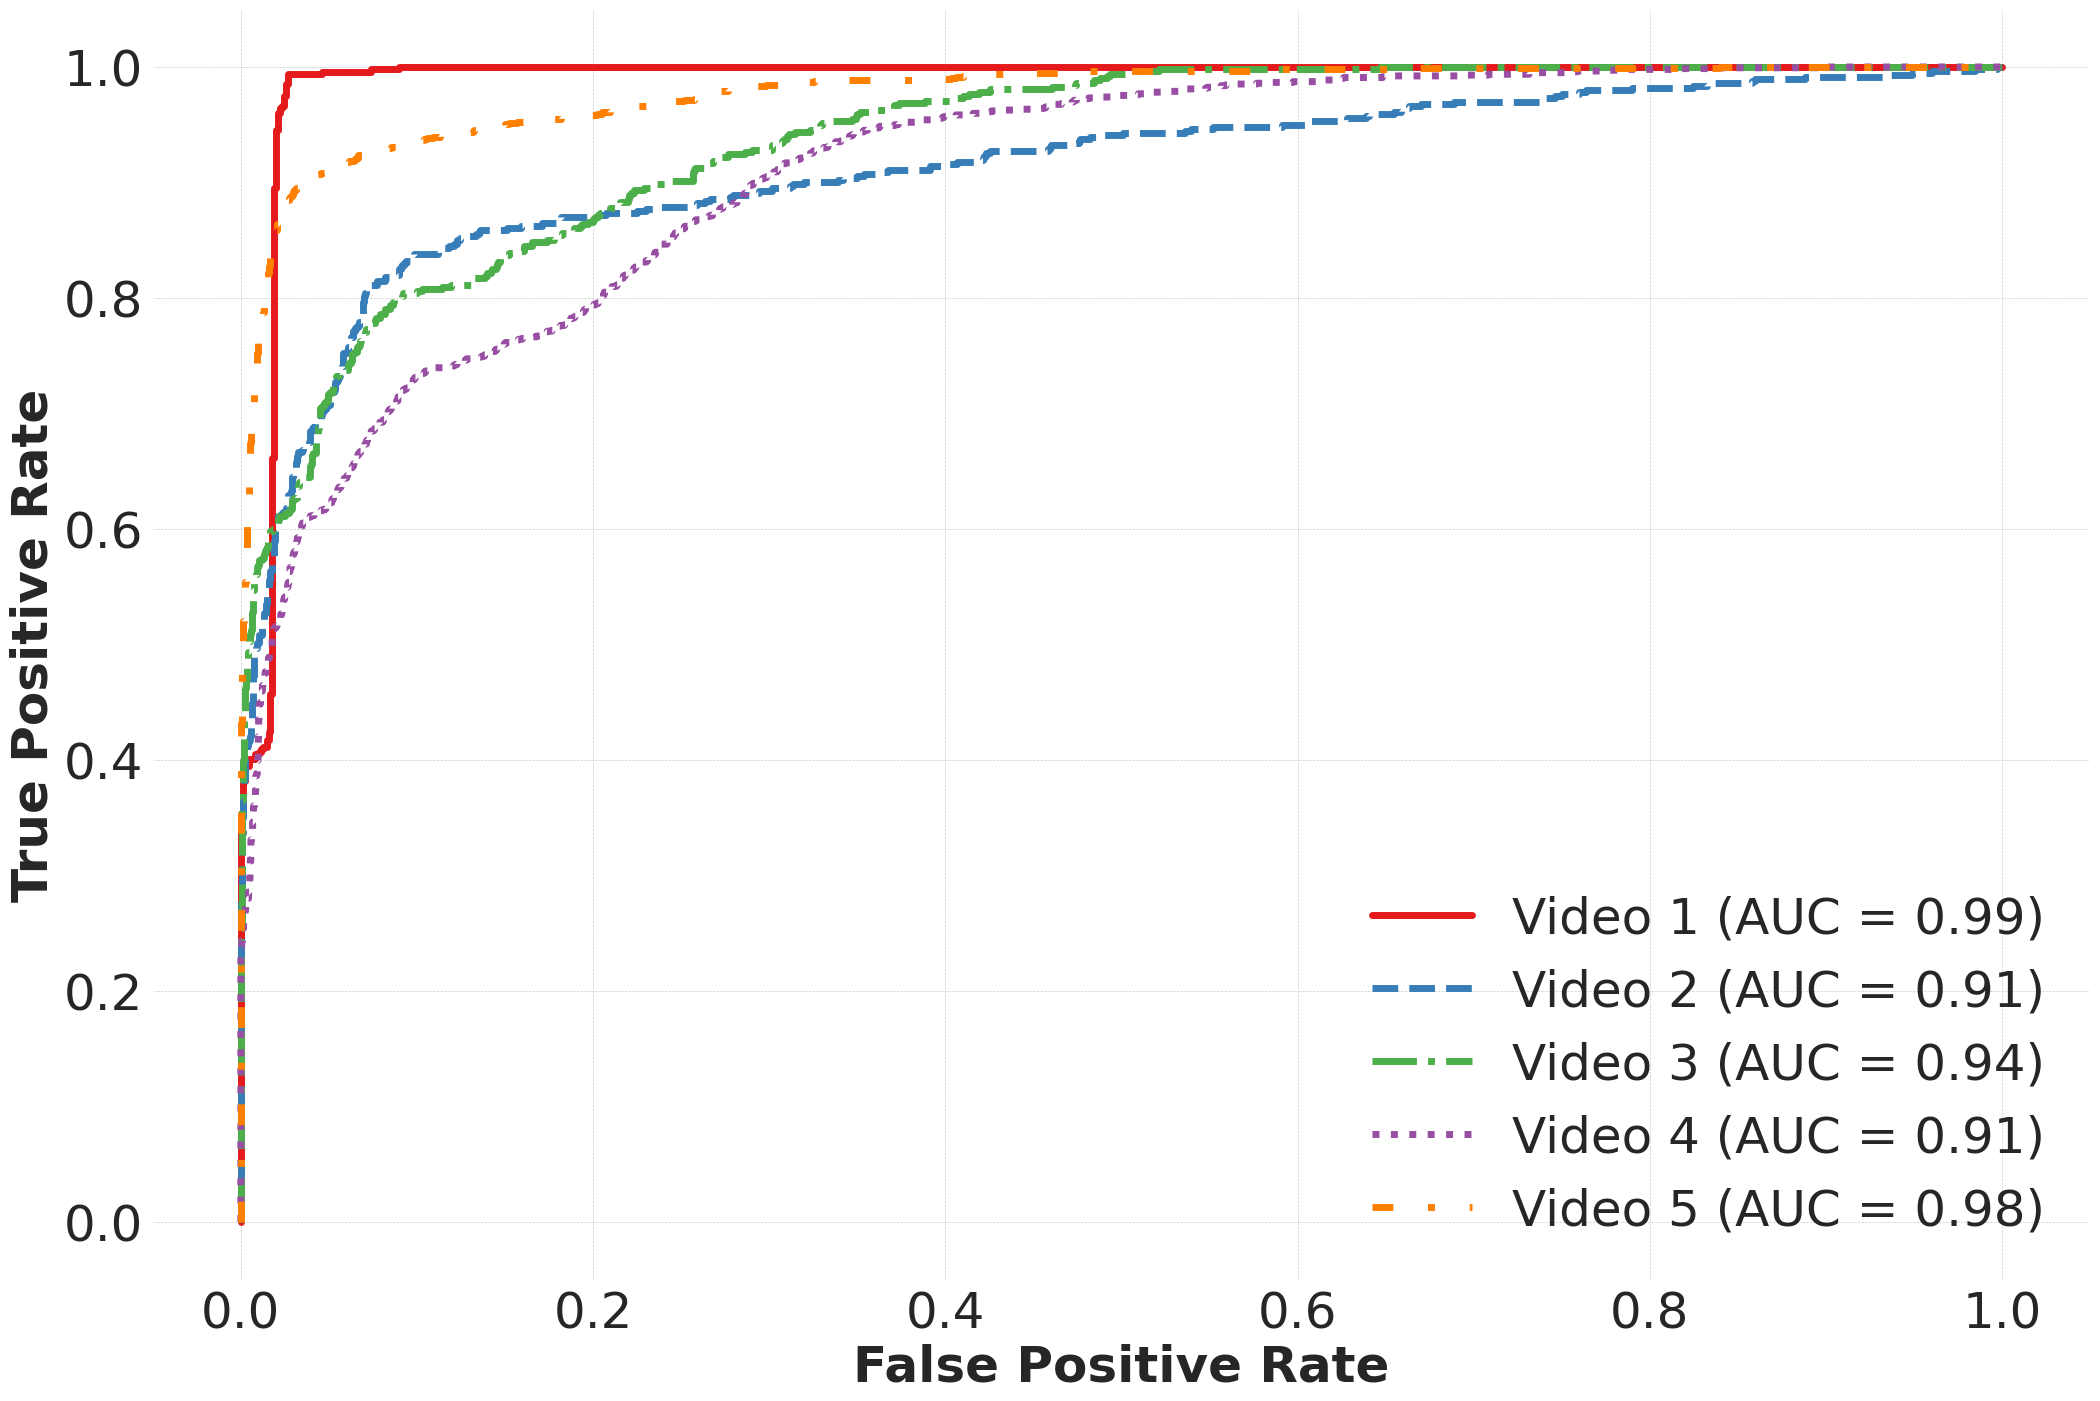

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Supposition que compute_roc_auc et les dataframes df1, df2, etc. sont déjà définis.

dataframes = {
    1: df1,
    2: df2,
    3: df3,
    4: df4,
    5: df5
}

# Utilisation de fig et ax
fig, ax = plt.subplots(figsize=(25, 16.5))
fig.set_facecolor('white')
ax.set_facecolor('white')

ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='#cccccc')

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
line_styles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5))]

for video_number in sorted(dataframes.keys()):
    df = dataframes[video_number]
    auc_roc = compute_roc_auc(df)
    fpr, tpr, _ = roc_curve(df['label'], df['proba_avg'])
    
    color = colors[video_number - 1] 
    line_style = line_styles[video_number - 1]
    
    ax.plot(fpr, tpr, label=f'Video {video_number} (AUC = {auc_roc:.2f})', 
            color=color, linestyle=line_style, linewidth=5.0)

ax.set_xlabel('False Positive Rate', fontsize=36, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=36, fontweight='bold')
ax.tick_params(labelsize=36)

ax.legend(loc='lower right', framealpha=0, fontsize=36)

# Sauvegarde avec fig.savefig
fig.savefig('roc_auc_ic.pdf', format='pdf', bbox_inches='tight', facecolor=fig.get_facecolor())

# Visualize temporal segmentation

In [24]:
def calculate_iou(true_labels, predicted_labels):
    intersection = np.logical_and(true_labels, predicted_labels)
    union = np.logical_or(true_labels, predicted_labels)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [86]:
# def plot_labels(df, second_plot_title, output_dir, file_name, ground_truth, labels=False):
#     df = df.sort_values(by='frame')
#     true_labels = df['label'].tolist()
# 
#     def plot_rectangles(labels, ax):
#         start = 0
#         current_label = labels[0]
#         for i, label in enumerate(labels):
#             if label != current_label or i == len(labels) - 1:
#                 end = i if label == current_label else i - 1
#                 color = 'white' if current_label == 'no' else '#bdbdbd'
#                 ax.axhspan(0, 1, xmin=start / len(labels), xmax=(end + 1) / len(labels), facecolor=color)
#                 start = i
#                 current_label = label
# 
#     if ground_truth:
#         if labels:
#             fig, axs = plt.subplots(2, 1, figsize=(15, 4))
#             ax_model = axs[1]
#             model_labels = df['pred_avg'].tolist() if second_plot_title == 'Average Model Predictions' else df['post_pred'].tolist()
#             plot_rectangles(model_labels, ax_model)
#             ax_model.set_title(second_plot_title, fontsize=18, fontweight='bold')
#             ax_model.set_yticks([])
#         else:
#             fig, ax_ground_truth = plt.subplots(1, 1, figsize=(15, 1.5))
#             axs = [ax_ground_truth]
#     else:
#         fig, ax_model = plt.subplots(1, 1, figsize=(15, 2))
#         axs = [ax_model]
#         model_labels = df['pred_avg'].tolist() if second_plot_title == 'Average Model Predictions' else df['post_pred'].tolist()
#         plot_rectangles(model_labels, ax_model)
#         ax_model.set_title(second_plot_title, fontsize=18, fontweight='bold')
# 
#     for ax in axs:
#         ax.set_xticks([])  
#         ax.set_yticks([])  
# 
#     if ground_truth:
#         ax_ground_truth = axs[0]
#         plot_rectangles(true_labels, ax_ground_truth)
#         #ax_ground_truth.set_title('Ground Truth', fontsize=18, fontweight='bold')
#         ax_ground_truth.set_yticks([])
# 
#     tick_interval = 500
#     frame_numbers = df['frame'].tolist()
#     xticks = np.arange(min(frame_numbers), max(frame_numbers) + tick_interval, tick_interval)
#     for ax in axs:
#         ax.set_xticks(xticks)
#         ax.set_xticklabels(xticks.astype(int))
#         ax.set_yticks([])
# 
#     ax_ground_truth.axhline(y=1, color='black', linewidth=1)  
#     ax_ground_truth.axhline(y=0, color='black', linewidth=1)  
#     box = ax_ground_truth.get_position()
#     ax_ground_truth.set_position([box.x0 + 0.0, box.y0, box.width * 0.95, box.height])
# 
#     fig.text(0.0, 0.6, 'Ground Truth', fontsize=14, fontweight='bold', verticalalignment='center', horizontalalignment='left')
#     fig.text(0.92, 0.6, f' a', fontsize=14, color='black', fontweight='bold', verticalalignment='center', horizontalalignment='left', rotation=0)
# 
# 
#     plt.xlabel('Frame Number', fontsize=14)
#     plt.tight_layout()
# 
#     label_rectangle_path = os.path.join(output_dir, str(file_name) + '_label_vis.pdf')
# 
#     plt.savefig(label_rectangle_path)
# 
#     plt.show()


In [106]:
# def plot_labels(df, second_plot_title, output_dir, file_name, ground_truth, labels=False):
#     df = df.sort_values(by='frame')
#     true_labels = df['label'].tolist()
# 
#     def plot_rectangles(labels, ax):
#         start = 0
#         current_label = labels[0]
#         for i, label in enumerate(labels):
#             if label != current_label or i == len(labels) - 1:
#                 end = i if label == current_label else i - 1
#                 color = 'white' if current_label == 'no' else '#bdbdbd'
#                 ax.axhspan(0, 1, xmin=start / len(labels), xmax=(end + 1) / len(labels), facecolor=color)
#                 start = i
#                 current_label = label
#         
#     fig, ax_model = plt.subplots(1, 1, figsize=(15, 1.5))
#     #axs = [ax_ground_truth]
# 
#     ax_model.set_xticks([])  
#     ax_model.set_yticks([])  
# 
#     ax_ground_truth = fig.axes[0]
#     plot_rectangles(true_labels, ax_model)
# 
#     tick_interval = 500
#     frame_numbers = df['frame'].tolist()
#     xticks = np.arange(min(frame_numbers), max(frame_numbers) + tick_interval, tick_interval)
#     
#     ax_model.set_xticks(xticks)
#     ax_model.set_xticklabels(xticks.astype(int))
#     ax_model.tick_params(axis='x', which='both', length=0)
# 
#     ax_model.axhline(y=1, color='black', linewidth=1)  
#     ax_model.axhline(y=0, color='black', linewidth=1)  
#     box = ax_model.get_position()
#     ax_model.set_position([box.x0 + 0.0, box.y0, box.width * 0.95, box.height])
# 
#     fig.text(0.0, 0.6, 'Ground Truth', fontsize=14, fontweight='bold', verticalalignment='center', horizontalalignment='left')
#     fig.text(0.92, 0.6, f' a', fontsize=14, color='black', fontweight='bold', verticalalignment='center', horizontalalignment='left', rotation=0)
# 
#     plt.xlabel('Frame Number', fontsize=14)
#     plt.tight_layout()
# 
#     label_rectangle_path = os.path.join(output_dir, str(file_name) + '_label_vis.pdf')
# 
#     plt.savefig(label_rectangle_path)
# 
#     plt.show()


In [132]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from pathlib import Path

def plot_labels(df, second_plot_title, output_dir, file_name, ground_truth, model_name):
    df = df.sort_values(by='frame')
    true_labels = df['label'].tolist() if ground_truth else None
    model_labels = df['pred_avg'].tolist() if second_plot_title == 'Average Model Predictions' else df['post_pred'].tolist()

    fig, ax_model = plt.subplots(figsize=(15, 1.5))
    ax_ground_truth = fig.axes[0] if ground_truth else None

    def plot_rectangles(labels, ax):
        start = 0
        current_label = labels[0]
        for i, label in enumerate(labels):
            if label != current_label or i == len(labels) - 1:
                end = i if label == current_label else i - 1
                color = 'white' if current_label == 0 else '#bdbdbd'
                ax.axhspan(0, 1, xmin=start / len(labels), xmax=(end + 1) / len(labels), facecolor=color)
                start = i
                current_label = label

    if ground_truth:
        plot_rectangles(true_labels, ax_ground_truth)
        ax_ground_truth.set_yticks([])

    #plot_rectangles(model_labels, ax_model)
    ax_model.set_yticks([])
    ax_model.set_xticks([])

    tick_interval = 500
    frame_numbers = df['frame'].tolist()
    xticks = np.arange(min(frame_numbers), max(frame_numbers) + tick_interval, tick_interval)
    ax_model.set_xticks(xticks)
    ax_model.set_xticklabels(xticks.astype(int), alpha=0.0)
    ax_model.tick_params(axis='x', which='both', length=0, color='white')

    ax_model.axhline(y=1, color='black', linewidth=1)  
    ax_model.axhline(y=0, color='black', linewidth=1)  
    box = ax_model.get_position()
    ax_model.set_position([box.x0 + 0.0, box.y0, box.width * 0.95, box.height])

    fig.text(0.0, 0.6, model_name, fontsize=14, fontweight='bold', verticalalignment='center', horizontalalignment='left')
    fig.text(0.92, 0.6, f' ', fontsize=14, color='white', fontweight='bold', verticalalignment='center', horizontalalignment='left', rotation=0)

    plt.xlabel('Frame Number', fontsize=14, alpha=0.0)
    plt.subplots_adjust(bottom=0.4) 

    label_rectangle_path = os.path.join(output_dir, str(file_name) + '_label_vis.pdf')
    plt.savefig(label_rectangle_path)
    plt.show()


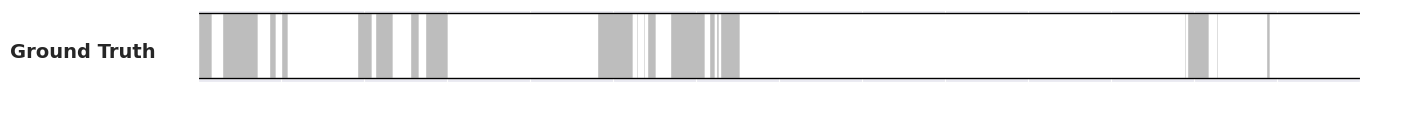

In [133]:
model = 'v20_rnn_nnunet'
name = 'ground truth'
root = Path(f'../output/benchmarking/sources/{model}')
for file in sorted(root.glob('*x5*.csv')):
    file_name = Path(file.stem)
    outputdir = '.'
    
    df = pd.read_csv(file)
    plot_labels(df, 'Average Model Predictions', output_dir=outputdir, file_name=name, ground_truth=True, model_name='Ground Truth')

IOU

In [81]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from pathlib import Path

def plot_labels(df, second_plot_title, output_dir, file_name, ground_truth, model_name, iou_score, negative_class='no', show_x_axis_data=True):
    df = df.sort_values(by='frame')
    true_labels = df['label'].tolist() if ground_truth else None
    model_labels = df['pred_avg'].tolist() if second_plot_title == 'Average Model Predictions' else df['post_pred'].tolist()

    fig, ax_model = plt.subplots(figsize=(15, 1.0 if not ground_truth else 4))
    ax_ground_truth = fig.axes[0] if ground_truth else None

    def plot_rectangles(labels, ax):
        start = 0
        current_label = labels[0]
        for i, label in enumerate(labels):
            if label != current_label or i == len(labels) - 1:
                end = i if label == current_label else i - 1
                color = 'white' if current_label == negative_class else '#636363'
                ax.axhspan(0, 1, xmin=start / len(labels), xmax=(end + 1) / len(labels), facecolor=color)
                start = i
                current_label = label

    if ground_truth:
        plot_rectangles(true_labels, ax_ground_truth)
        ax_ground_truth.set_title('Ground Truth', fontsize=18, fontweight='bold')
        ax_ground_truth.set_yticks([])

    plot_rectangles(model_labels, ax_model)
    ax_model.set_yticks([])
    ax_model.set_xticks([])

    if show_x_axis_data:
        tick_interval = 500
        frame_numbers = df['frame'].tolist()
        xticks = np.arange(min(frame_numbers), max(frame_numbers) + tick_interval, tick_interval)
        ax_model.set_xticks(xticks)
        ax_model.set_xticklabels(xticks.astype(int))
        ax_model.tick_params(axis='x', which='both', length=0)

    ax_model.axhline(y=1, color='black', linewidth=1)  
    ax_model.axhline(y=0, color='black', linewidth=1)  
    box = ax_model.get_position()
    ax_model.set_position([box.x0 + 0.0, box.y0, box.width * 0.95, box.height])

    fig.text(0.0, 0.6, model_name, fontsize=14, fontweight='bold', verticalalignment='center', horizontalalignment='left')
    fig.text(0.92, 0.6, f'IoU {iou_score:.2f}', fontsize=14, color='black', fontweight='bold', verticalalignment='center', horizontalalignment='left', rotation=0)

    if show_x_axis_data:
        plt.xlabel('Frame Number', fontsize=14)
        plt.subplots_adjust(bottom=0.4) 

    label_rectangle_path = os.path.join(output_dir, str(file_name) + '_label_vis.pdf')
    plt.savefig(label_rectangle_path)
    plt.show()


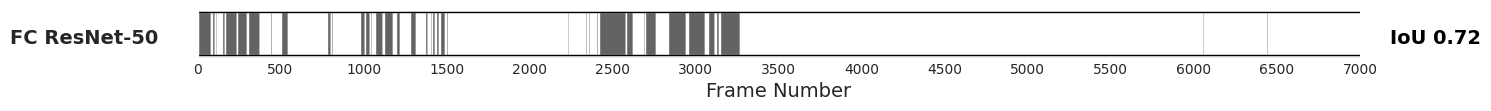

In [85]:
model = 'v25_fc_resnet'
#name = 'nnU-Net'
name = 'FC ResNet-50'
root = Path(f'../output/benchmarking/sources/{model}')
transfo = True
for file in sorted(root.glob('*x5*.csv')):
    file_name = Path(file.stem)
    outputdir = '.'
    
    df = pd.read_csv(file)
    if transfo:
        df['label'] = df['label'].replace({'no': 0, 'spur': 1})
        df['pred_avg'] = df['pred_avg'].replace({'no': 0, 'spur': 1})
    true_labels = df['label'] == 1
    predicted_labels = df['pred_avg'] > 0.5 

    iou_score = calculate_iou(true_labels, predicted_labels)

    plot_labels(df, 'Average Model Predictions', output_dir=outputdir, file_name=model, ground_truth=False, model_name=name, iou_score=iou_score, negative_class=0, show_x_axis_data=True)
